['ML1M-Gender.txt', 'olivetti_faces.npy', 'netflix.txt', 'olivetti_faces_target.npy', 'Gender_200000_ML_sintetico_2000_800_03.txt', 'movielens-ratings1M_original.txt', 'ratings_gender.csv', 'ML100K-Gender (1).txt', 'Gender_200000_ML_sintetico_2000_800_01.txt', 'Gender_200000_ML_sintetico_2000_800_05.txt', 'Gender_200000_ML_sintetico_1000_800_03.txt', 'movielens-ratings1M.txt']
pics:  (400, 64, 64)
labels:  (400,)


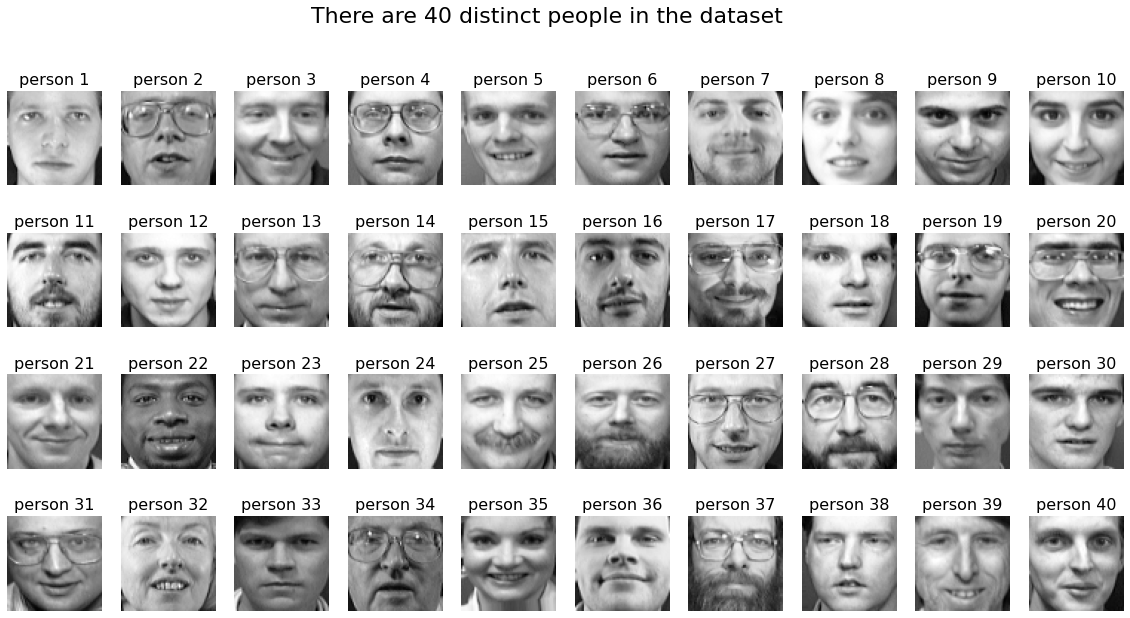

In [1]:
import random
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

import os
print(os.listdir("datasets"))

pics = np.load("datasets/olivetti_faces.npy")
labels = np.load("datasets/olivetti_faces_target.npy")
print("pics: ", pics.shape)
print("labels: ", labels.shape)

fig = plt.figure(figsize=(20, 10))
columns = 10
rows = 4
for i in range(1, columns*rows +1):
    img = pics[10*(i-1),:,:]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap = plt.get_cmap('gray'))
    plt.title("person {}".format(i), fontsize=16)
    plt.axis('off')
    
plt.suptitle("There are 40 distinct people in the dataset", fontsize=22)
plt.show()

Xdata = pics # store images in Xdata
Ydata = labels.reshape(-1,1) # store labels in Ydata


In [2]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(Xdata, Ydata, test_size = 0.15, random_state=46)

NUM_USERS = 10

print("x_train: ",x_train.shape)
print("x_test: ",x_test.shape)
print("y_train: ",y_train.shape)
print("y_test: ",y_test.shape)

x_train = np.array(x_train.reshape(-1,64,64,1))
x_test = np.array(x_test.reshape(-1,64,64,1))

print("x_train: ",x_train.shape)
print("x_test: ",x_test.shape)

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

y_train_ = np.array(to_categorical(y_train, num_classes = 40)) # 40 distinct people
y_test_ = np.array(to_categorical(y_test, num_classes = 40))

print("y_train_ shape: ",y_train_.shape)
print("y_test_ shape: ",y_test_.shape)

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop


class Faces_Recognition:
    @staticmethod
    def build(shape, classes):
        model = Sequential()

        model.add(Conv2D(filters = 20, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = shape))

        model.add(MaxPool2D(pool_size=(2,2)))
        model.add(Dropout(0.25))

        model.add(Conv2D(filters = 50, kernel_size = (6,6),padding = 'Same', 
                 activation ='relu'))

        model.add(MaxPool2D(pool_size=(2,2)))
        model.add(Dropout(0.25))

        model.add(Conv2D(filters = 150, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = shape))

        model.add(Flatten())
        model.add(Dense(256, activation = "relu"))
        model.add(Dropout(0.6))
        model.add(Dense(40, activation = "softmax"))

        optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
        model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

        return model
    

x_train:  (340, 64, 64)
x_test:  (60, 64, 64)
y_train:  (340, 1)
y_test:  (60, 1)
x_train:  (340, 64, 64, 1)
x_test:  (60, 64, 64, 1)
y_train_ shape:  (340, 40)
y_test_ shape:  (60, 40)


In [3]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

epoch = 4
batch_size = 4

#initialize global model
smlp_global = Faces_Recognition()
global_model = smlp_global.build((64,64,1), NUM_USERS)

epoch = 60
batch_size = 20

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=5,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.05, # Randomly zoom image 
        width_shift_range=0,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
datagen.fit(x_train)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.7, 
                                            min_lr=0.00000000001)
history = global_model.fit_generator(
                              datagen.flow(x_train,y_train_, batch_size=batch_size),
                              epochs = epoch, 
                              validation_data = (x_test,y_test_),
                              verbose = 2, 
                              steps_per_epoch=x_train.shape[0] // batch_size,
                              callbacks=[learning_rate_reduction]
                             )

Epoch 1/60
17/17 - 3s - loss: 6.3393 - accuracy: 0.0265 - val_loss: 3.6908 - val_accuracy: 0.0000e+00 - lr: 0.0010 - 3s/epoch - 174ms/step
Epoch 2/60
17/17 - 1s - loss: 3.6974 - accuracy: 0.0235 - val_loss: 3.6966 - val_accuracy: 0.0167 - lr: 0.0010 - 669ms/epoch - 39ms/step
Epoch 3/60
17/17 - 1s - loss: 3.6932 - accuracy: 0.0176 - val_loss: 3.6950 - val_accuracy: 0.0000e+00 - lr: 0.0010 - 659ms/epoch - 39ms/step
Epoch 4/60
17/17 - 1s - loss: 3.6890 - accuracy: 0.0235 - val_loss: 3.7403 - val_accuracy: 0.0000e+00 - lr: 0.0010 - 641ms/epoch - 38ms/step
Epoch 5/60

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.
17/17 - 1s - loss: 3.6785 - accuracy: 0.0235 - val_loss: 3.6971 - val_accuracy: 0.0000e+00 - lr: 0.0010 - 616ms/epoch - 36ms/step
Epoch 6/60
17/17 - 1s - loss: 3.7015 - accuracy: 0.0176 - val_loss: 3.7005 - val_accuracy: 0.0000e+00 - lr: 7.0000e-04 - 661ms/epoch - 39ms/step
Epoch 7/60
17/17 - 1s - loss: 3.6928 - accuracy: 0.0176 - val_loss: 3.7007 - va

Epoch 53/60
17/17 - 1s - loss: 0.0976 - accuracy: 0.9735 - val_loss: 0.1072 - val_accuracy: 0.9667 - lr: 1.3841e-05 - 602ms/epoch - 35ms/step
Epoch 54/60

Epoch 54: ReduceLROnPlateau reducing learning rate to 9.688900263427058e-06.
17/17 - 1s - loss: 0.0994 - accuracy: 0.9706 - val_loss: 0.1032 - val_accuracy: 0.9667 - lr: 1.3841e-05 - 594ms/epoch - 35ms/step
Epoch 55/60
17/17 - 1s - loss: 0.0759 - accuracy: 0.9853 - val_loss: 0.1042 - val_accuracy: 0.9667 - lr: 9.6889e-06 - 612ms/epoch - 36ms/step
Epoch 56/60
17/17 - 1s - loss: 0.0547 - accuracy: 0.9882 - val_loss: 0.1046 - val_accuracy: 0.9667 - lr: 9.6889e-06 - 597ms/epoch - 35ms/step
Epoch 57/60

Epoch 57: ReduceLROnPlateau reducing learning rate to 6.782229866075795e-06.
17/17 - 1s - loss: 0.0580 - accuracy: 0.9853 - val_loss: 0.1072 - val_accuracy: 0.9667 - lr: 9.6889e-06 - 596ms/epoch - 35ms/step
Epoch 58/60
17/17 - 1s - loss: 0.0656 - accuracy: 0.9853 - val_loss: 0.1056 - val_accuracy: 0.9667 - lr: 6.7822e-06 - 604ms/epoch - 36

In [4]:
def weight_scalling_factor(weight, num_users):
    scalar = 1 / num_users
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final

def sum_scaled_weights(scaled_weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''
    avg_grad = list()
    #get the average grad accross all client gradients
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)        
    return avg_grad

In [5]:
smlp = Faces_Recognition()

local_model = list()  # each client has its own model
for _ in range(NUM_USERS):
    local_model.append(smlp.build((64,64,1), NUM_USERS))

shard_size = len(x_train)//NUM_USERS
master = random.randint(0,NUM_USERS-1)

federated_loops = 30
#commence global training loop
for current_loop in range(federated_loops):
    print(federated_loops-current_loop)            
    # get the global model's weights - will serve as the initial weights for all local models
    master_weights = local_model[master].get_weights()
    
    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()
             
    #loop through each client and create new local model 
    for client in range(NUM_USERS):      
        #set local model weight to the weight of the global model
        local_model[client].set_weights(master_weights) 
        #fit local model with client's data
        
        for i in range(12):  # 12 is an arbitrary value
            shard_begin = client*shard_size
            shard_end = (client+1)*shard_size-1
            local_model[client].fit_generator(  
                              datagen.flow(x_train[shard_begin:shard_end],y_train_[shard_begin:shard_end], batch_size=4),
                              epochs = 6, verbose = 0, 
                              steps_per_epoch = 32 // batch_size,
                             )
        
        #scale the model weights and add to list
        scaled_weights = weight_scalling_factor(local_model[client].get_weights(), NUM_USERS)
        scaled_local_weight_list.append(scaled_weights)
    
    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    
    # randomly assign a master and update its model 
    master = random.randint(0, NUM_USERS-1)
    local_model[master].set_weights(average_weights)
    local_model[master].evaluate(x_test,y_test_,verbose=1)
    

30
2/2 [==============================] - 0s 29ms/step - loss: 3.6912 - accuracy: 0.0000e+00
29
2/2 [==============================] - 0s 25ms/step - loss: 3.6945 - accuracy: 0.0000e+00
28
2/2 [==============================] - 0s 24ms/step - loss: 3.7090 - accuracy: 0.0000e+00
27
2/2 [==============================] - 0s 25ms/step - loss: 3.7034 - accuracy: 0.0167
26
2/2 [==============================] - 0s 24ms/step - loss: 3.5506 - accuracy: 0.0667
25
2/2 [==============================] - 0s 20ms/step - loss: 2.6554 - accuracy: 0.4000
24
2/2 [==============================] - 0s 22ms/step - loss: 1.4893 - accuracy: 0.7833
23
2/2 [==============================] - 0s 25ms/step - loss: 0.7214 - accuracy: 0.8000
22
2/2 [==============================] - 0s 24ms/step - loss: 0.4794 - accuracy: 0.8500
21
2/2 [==============================] - 0s 25ms/step - loss: 0.3856 - accuracy: 0.8500
20
2/2 [==============================] - 0s 24ms/step - loss: 0.3619 - accuracy: 0.8667
19
2/2 [=